# Distributed Dask Kubernetes experiment

In [1]:
from dask.distributed import Client
client = Client("localhost:8786")

/home/ryan/miniconda3/envs/dask-test/lib/python3.10/site-packages/distributed/client.py:1582: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| lz4     | 4.3.2  | 4.3.3     | 4.3.3   |
| msgpack | 1.1.1  | 1.1.0     | 1.1.0   |
| numpy   | 2.2.5  | 2.2.6     | 2.2.6   |
| toolz   | 1.0.0  | 0.12.0    | 0.12.0  |
| tornado | 6.5.1  | 6.5       | 6.5     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


We successfully connected to our baby Dask Kubernetes cluster and it is whining about python libraries being mismatched. The versions on the scheduler and workers are were installed when we used the Dask helm chart to get set up. The client Python and Dask versions needed to be manually reconciled - hence these are not on the list.

8786 is the Dask port we have forwarded to our cluster using `kubectl`. 8787 also works for the Dask dashboard. We used Terraform to spin up this k8s cluster on AWS EKS; it did not appear that the VPC settings could be changed from the AWS console when I attempted it.

See the infrastructure folder in the repo for the copy+pasted Terraform example files.

In [3]:
client

<Client: 'tcp://10.0.2.175:8786' processes=2 threads=4, memory=3.76 GiB>

Everything looks in order. Let's play a little with vanilla Dask before fiddling with Dask-Geopandas.

I am going to just manually set up an S3 bucket using the AWS console and throw in the [Stock Market Dataset](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset?resource=download) from Kaggle.

In [5]:
def install_s3fs():
    import subprocess
    subprocess.check_call(["pip", "install", "s3fs"])

# Install on all workers
client.run(install_s3fs)

# Install on the scheduler
client.run_on_scheduler(install_s3fs)

In [ ]:
!pip install s3fs

Needed to install s3fs to access the bucket. This is not persistent, but will suffice for now.

In [29]:
import dask.dataframe as dd

# Read all CSV files from the S3 bucket
df = dd.read_csv('s3://ryan-fun-aws-experiments/stocks/*.csv', 
                 storage_options={
                    'key': '',
                    'secret': '',
                    },
                dtype={'Volume': 'float64'})

# Perform operations on the Dask DataFrame
print(df.head())

         Date       Open       High        Low      Close  Adj Close  \
0  1999-11-18  32.546494  35.765381  28.612303  31.473534  27.068665   
1  1999-11-19  30.713520  30.758226  28.478184  28.880543  24.838577   
2  1999-11-22  29.551144  31.473534  28.657009  31.473534  27.068665   
3  1999-11-23  30.400572  31.205294  28.612303  28.612303  24.607880   
4  1999-11-24  28.701717  29.998211  28.612303  29.372318  25.261524   

       Volume  
0  62546300.0  
1  15234100.0  
2   6577800.0  
3   5975600.0  
4   4843200.0  


In [24]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [33]:
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 32.0 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [35]:
from scipy.stats import mode

# Define the columns to calculate statistics for
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Calculate mean, median, and mode for each column
results = {}
for col in columns:
    mean = df[col].mean().compute()
    median = df[col].median_approximate().compute()
    mode_value = mode(df[col].compute(), nan_policy='omit').mode[0]  # Compute mode using scipy.stats.mode
    
    results[col] = {
        'mean': mean,
        'median': median,
        'mode': mode_value
    }

# Print the results
for col, stats in results.items():
    print(f"{col}: Mean = {stats['mean']}, Median = {stats['median']}, Mode = {stats['mode']}")

2025-07-13 10:53:32,414 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('repartitiontofewer-f8c12fcef5787f89b1642799ba0b36ef', 0),)
2025-07-13 10:56:34,839 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('repartitiontofewer-f8c12fcef5787f89b1642799ba0b36ef', 0),)
2025-07-13 10:59:34,620 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('repartitiontofewer-f8c12fcef5787f89b1642799ba0b36ef', 0),)


KeyboardInterrupt: 

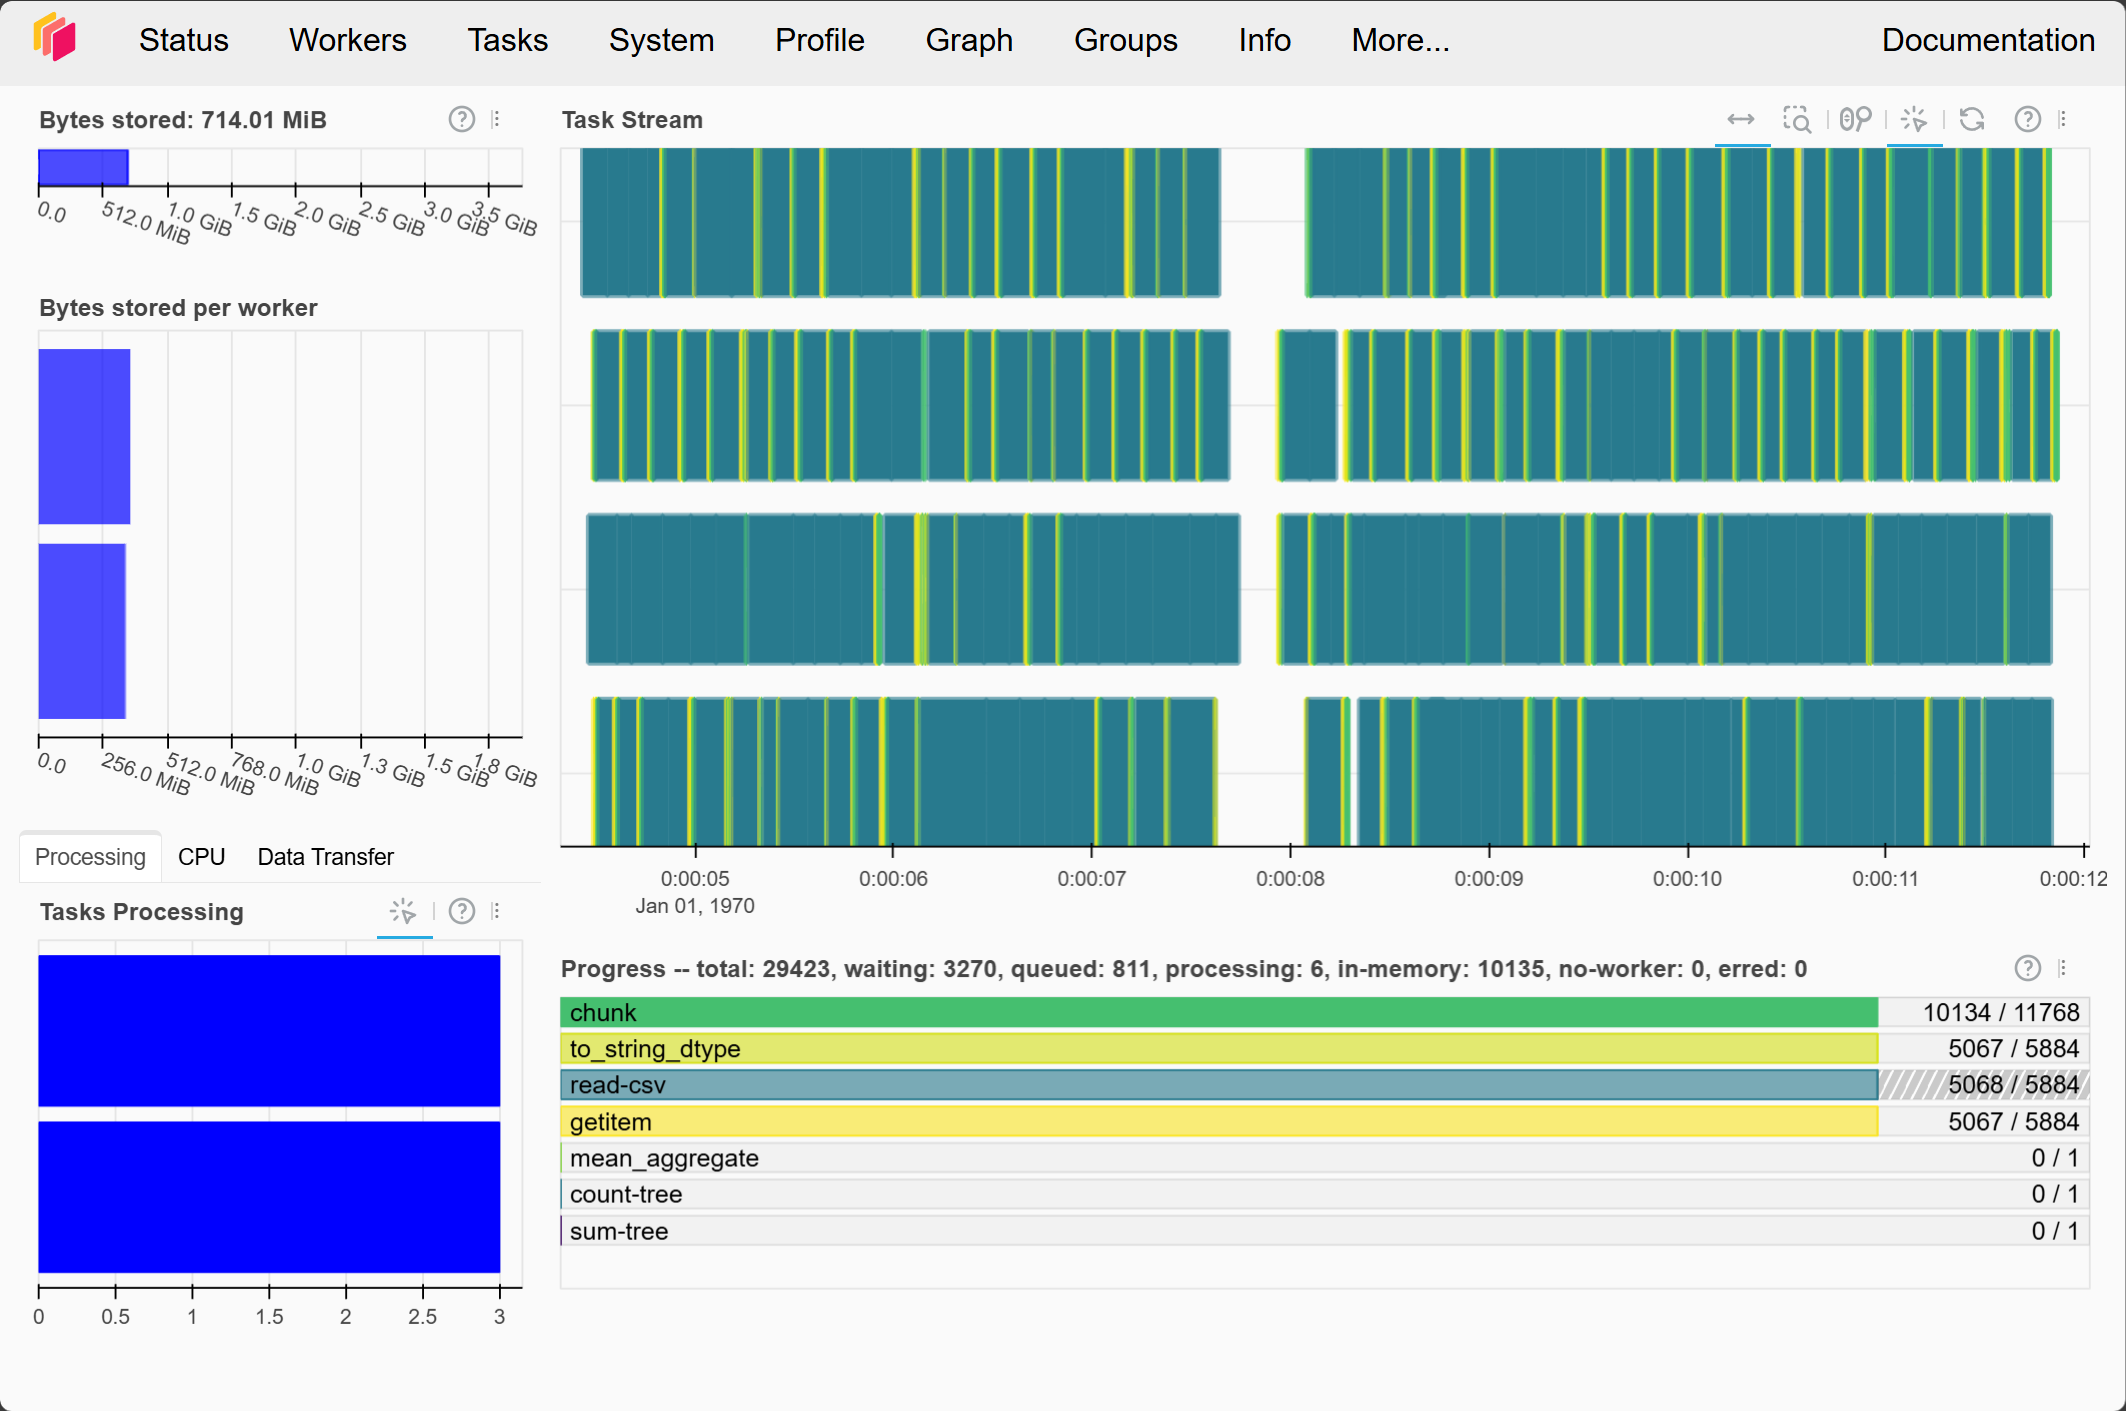
Looks like this is taxing the cluster - as opposed to running locally. It's running pretty slow but we are not throwing much horsepower at it. Regular Pandas would probably do this much quicker, but would not scale.

Looks like it is particularly struggling with the mode calculation - see the warnings. Let's forget the mode and just do mean and median instead of messing with partitioning on these whimpy little nodes. This is more of an infrastructure project anyway.

In [36]:
# Define the columns to calculate statistics for
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Calculate mean and median for each column
results = {}
for col in columns:
    mean = df[col].mean().compute()
    median = df[col].median_approximate().compute()
    
    results[col] = {
        'mean': mean,
        'median': median
    }

# Print the results
for col, stats in results.items():
    print(f"{col}: Mean = {stats['mean']}, Median = {stats['median']}")


Open: Mean = 3100384.2938410565, Median = 26.86000061035156
High: Mean = 3162820.812312623, Median = 27.385999679565433
Low: Mean = 3021934.6139424318, Median = 26.3799991607666
Close: Mean = 3087170.5351943327, Median = 26.8700008392334
Adj Close: Mean = -7.217705541103272e+16, Median = 21.396955490112305
Volume: Mean = 1102490.1226620404, Median = 1022116.0


Yeah that took forever and would be faster using Pandas. But the lesson here stands.

## Conclusion
We deployed an AWS Elastic Kubernetes Service cluster using Terraform. We then set up a Dask cluster on top of that Kubernetes cluster and were able to do something useful with Dask. 

Useful tutorials:
- [Terraform EKS Tutorial](https://developer.hashicorp.com/terraform/tutorials/kubernetes/eks) - Learn how to provision an EKS cluster using Terraform.
- [Dask Kubernetes Documentation](https://kubernetes.dask.org/en/latest/) - Official documentation for deploying Dask on Kubernetes.
- [Dask Kubernetes Tutorial (YouTube)](https://www.youtube.com/watch?v=sHdVA6GWWZI) - A video tutorial on deploying Dask